In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import PIL
from tensorflow.keras import Model

In [3]:
def gram_matrix(tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd',tensor,tensor)
  gram_matrix = tf.expand_dims(result,axis=0)
  input_shape = tf.shape(tensor)
  i_j = tf.cast(input_shape[1]*input_shape[2],tf.float32)
  return gram_matrix/i_j

In [32]:
def load_vgg():
  vgg = tf.keras.applications.VGG19(include_top=True,weights=None)
  vgg.load_weights('/content/vgg19_weights_tf_dim_ordering_tf_kernels.h5')
  vgg.trainable = False
  content_layers = ['block4_conv2']
  style_layers = ['block1_conv1','block2_conv1','block3_conv1','block4_conv1','block5_conv1']
  content_output = vgg.get_layer(content_layers[0]).output
  style_output = [vgg.get_layer(style_layer).output for style_layer in style_layers]

  gram_style_output = [gram_matrix(output) for output in style_output]
  model = Model([vgg.input],[content_output,gram_style_output])
  return model

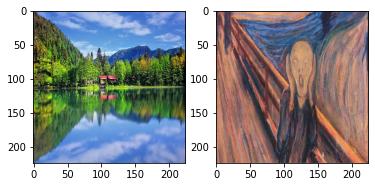

In [63]:
content_image = cv2.resize(cv2.imread('/content/manzara.jpg'), (224, 224))
content_image = tf.image.convert_image_dtype(content_image, tf.float32)
style_image = cv2.resize(cv2.imread('/content/cıglık.jpg'), (224, 224))
style_image = tf.image.convert_image_dtype(style_image, tf.float32)
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(np.array(content_image), cv2.COLOR_BGR2RGB))
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(np.array(style_image), cv2.COLOR_BGR2RGB))
plt.show()

In [12]:
optimizer = tf.optimizers.Adam(learning_rate=0.01,beta_1=0.99,epsilon=1e-1)

In [14]:
def loss_object(style_outputs, content_outputs,style_target,content_target):
  style_weight,content_weight = 1e-2,1e-1
  content_loss = tf.reduce_mean((content_outputs-content_target)**2)
  style_loss = tf.add_n([tf.reduce_mean((output-target)**2) for output,target in zip(style_outputs,style_target)])
  total_loss = content_loss*content_weight + style_loss*style_weight
  return total_loss

In [35]:
vgg_model = load_vgg()
content_target = vgg_model(np.array([content_image*255]))[0]
style_target = vgg_model(np.array([style_image*255]))[1]


In [40]:
def train_step(image,epoch):
  with tf.GradientTape() as tape:
    output = vgg_model(image*255)
    loss = loss_object(output[1], output[0], style_target, content_target)
  gradient = tape.gradient(loss,image)
  optimizer.apply_gradients([(gradient,image)])
  image.assign(tf.clip_by_value(image,clip_value_min=0.0,clip_value_max=1.0))

  if epoch % 100 ==0:
    print(f"Loss = {loss}")

In [61]:
EPOCHS = 1500
image = tf.image.convert_image_dtype(content_image, tf.float32)
image = tf.Variable([image])
for i in range(EPOCHS):
  train_step(image, i)

Loss = 2933299968.0
Loss = 162969904.0
Loss = 41652688.0
Loss = 16483463.0
Loss = 8847150.0
Loss = 5763719.0
Loss = 4308237.5
Loss = 3527409.25
Loss = 3048492.25
Loss = 2721991.75
Loss = 2488474.25
Loss = 2310829.5
Loss = 2167116.0
Loss = 2048207.875
Loss = 1946880.375


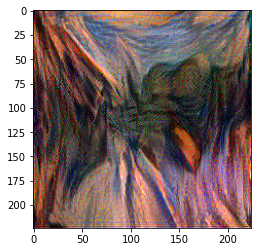

In [62]:
tensor = image*255
tensor = np.array(tensor, dtype=np.uint8)
if np.ndim(tensor)>3:
  assert tensor.shape[0] == 1
  tensor = tensor[0]
tensor =  PIL.Image.fromarray(tensor)
plt.imshow(cv2.cvtColor(np.array(tensor), cv2.COLOR_BGR2RGB))
plt.savefig('result.png')
plt.show()